In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'

Mounted at /content/drive
/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset


In [ ]:
from builtins import range, input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

#training config:
epochs = 10
batch_size = 32

#define paths
covid_path = 'COVID'
noncovid_path = 'Normal'

#Use glob to grab images from path.jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ", noncovid_files [0:5])
print("Total Count: ", len (noncovid_files))

First 5 Covid Files:  ['COVID/COVID-1000.png', 'COVID/COVID-1065.png', 'COVID/COVID-1013.png', 'COVID/COVID-1069.png', 'COVID/COVID-1001.png']
Total Count:  179
First 5 NonCovid Files:  ['Normal/Normal-10123.png', 'Normal/Normal-1015.png', 'Normal/Normal-10003.png', 'Normal/Normal-1002.png', 'Normal/Normal-10087.png']
Total Count:  162


In [ ]:
#Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []
covid_images=[]
noncovid_images= []
for i in range (len (covid_files)):
  image = cv2.imread(covid_files[i]) # read file
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #arrange format as per keras
  image = cv2.resize(image, (224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('COVID') #append class label
for i in range (len (noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Normal')

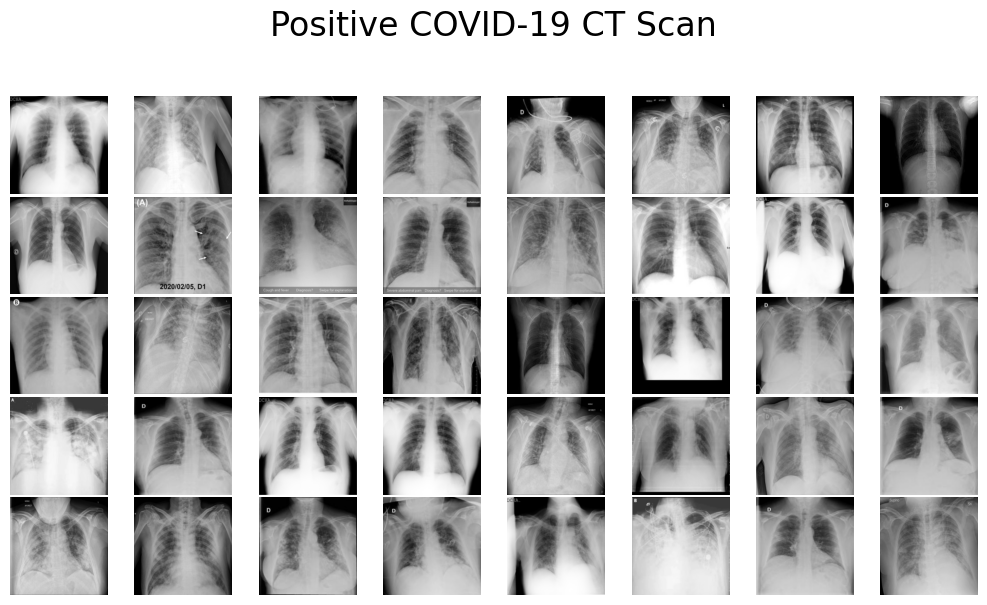

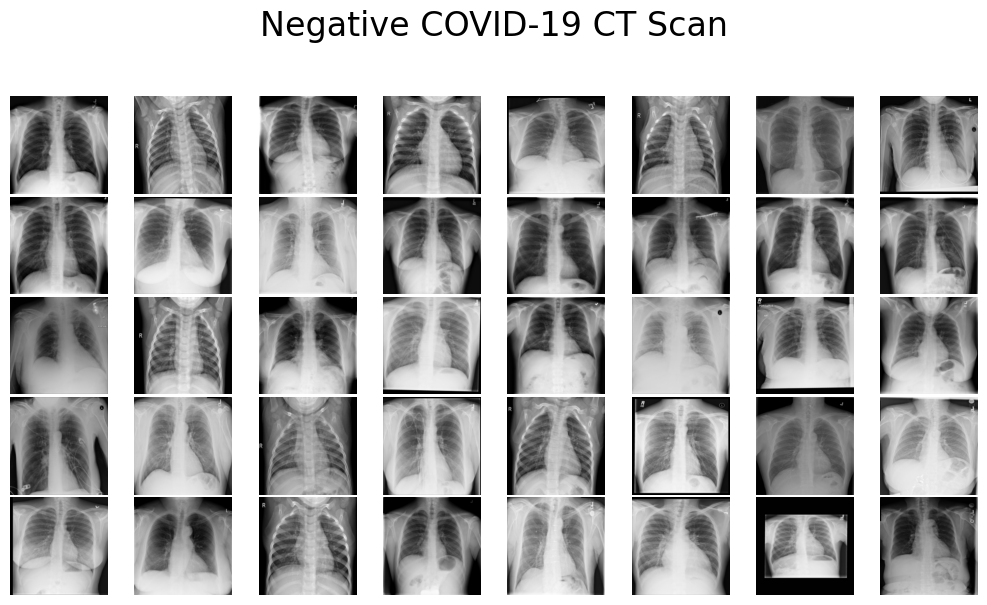

In [ ]:
def plot_images(images, title):
    nrows, ncols = min(5, len(images)), 8  # Limit number of rows to 5 or the length of images array, whichever is smaller
    figsize = [10, 6]
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
    for i, axi in enumerate(ax.flat):
        if i < len(images):  # Check if index is within range of the images array
            axi.imshow(images[i])
            axi.set_axis_off()
    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images (covid_images, 'Positive COVID-19 CT Scan')
plot_images (noncovid_images, 'Negative COVID-19 CT Scan')

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test =train_test_split(noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images.
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

#Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical (y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

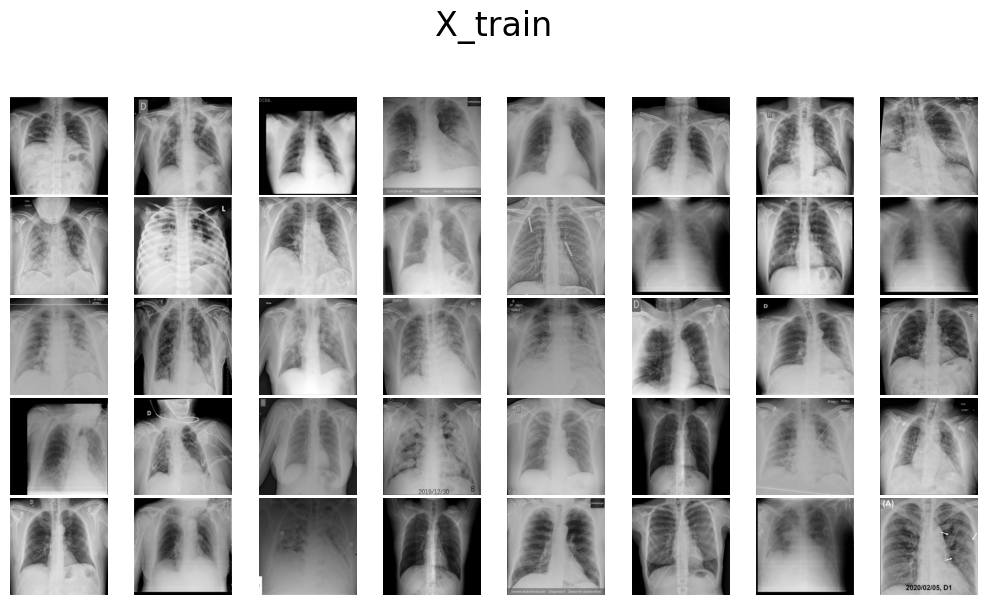

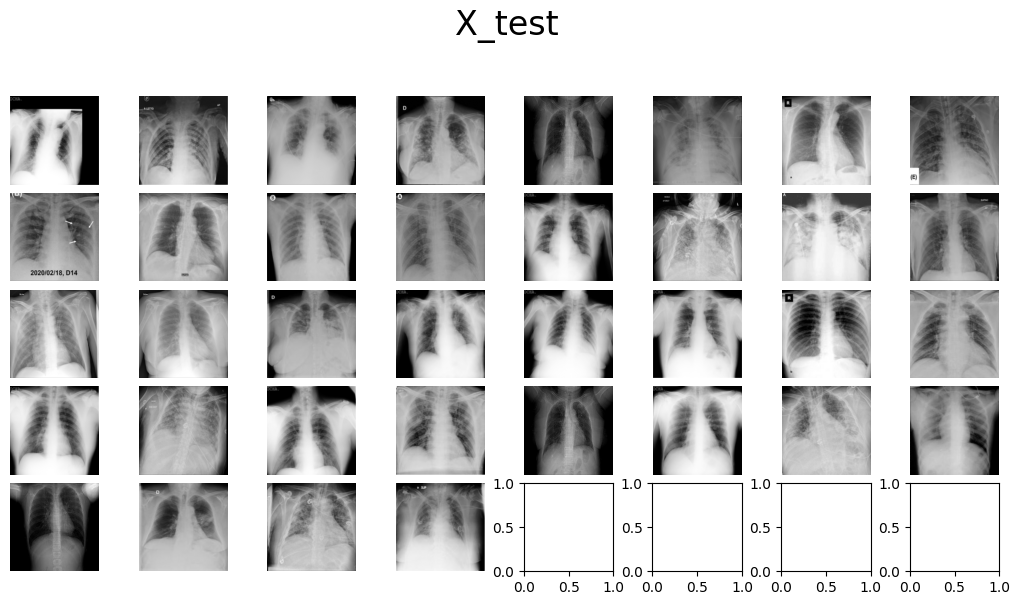

In [ ]:
plot_images (covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')


In [ ]:
#Building Model
vggModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input (shape=(224, 224, 3)))
outputs = vggModel.output
outputs = Flatten (name="flatten") (outputs)
outputs = Dropout (0.5) (outputs)
outputs = Dense (2, activation="sigmoid") (outputs)
model = Model (inputs=vggModel.input, outputs=outputs)
for layer in vggModel.layers:
  layer.trainable = False
model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
train_aug = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  horizontal_flip=True
)

In [ ]:
history = model.fit (train_aug.flow (X_train, y_train, batch_size=batch_size),
validation_data=(X_test, y_test),
validation_steps=len(X_test) / batch_size,
steps_per_epoch=len(X_train) / batch_size,
        epochs=epochs)
#Save Model and Weights
model.save('vgg_ct.h5')
model.save_weights('vgg_weights_ct.hdf5')
#Load saved model
model = load_model('vgg_ct.h5')

Epoch 1/10
8/8 [==============================] - 20s 1s/step - loss: 0.9769 - accuracy: 0.5735 - val_loss: 0.4808 - val_accuracy: 0.8116
Epoch 2/10
8/8 [==============================] - 4s 432ms/step - loss: 0.6979 - accuracy: 0.6765 - val_loss: 0.5478 - val_accuracy: 0.8116
Epoch 3/10
8/8 [==============================] - 3s 389ms/step - loss: 0.6990 - accuracy: 0.7169 - val_loss: 0.6958 - val_accuracy: 0.7536
Epoch 4/10
8/8 [==============================] - 4s 449ms/step - loss: 0.6407 - accuracy: 0.7610 - val_loss: 0.4932 - val_accuracy: 0.7391
Epoch 5/10
8/8 [==============================] - 4s 485ms/step - loss: 0.4653 - accuracy: 0.7721 - val_loss: 0.4348 - val_accuracy: 0.8116
Epoch 6/10
8/8 [==============================] - 3s 388ms/step - loss: 0.3840 - accuracy: 0.8199 - val_loss: 0.3738 - val_accuracy: 0.7826
Epoch 7/10
8/8 [==============================] - 3s 431ms/step - loss: 0.3857 - accuracy: 0.8235 - val_loss: 0.4050 - val_accuracy: 0.8406
Epoch 8/10
8/8 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 161ms/step


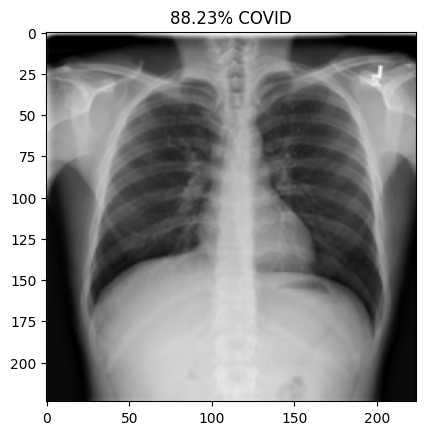

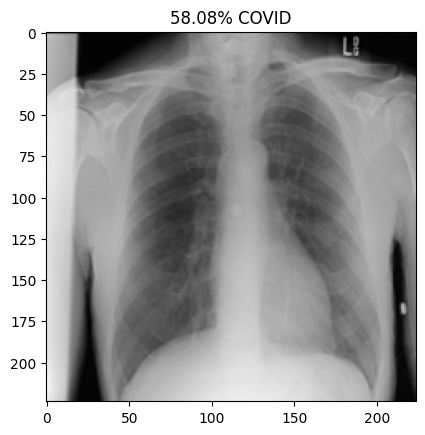

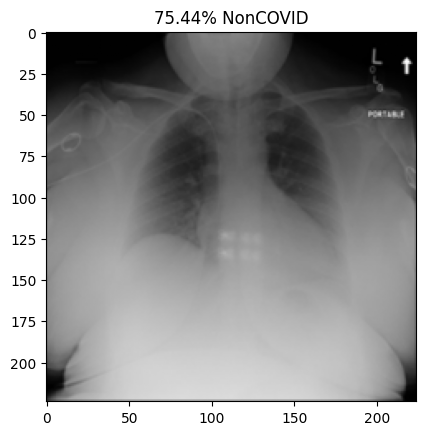

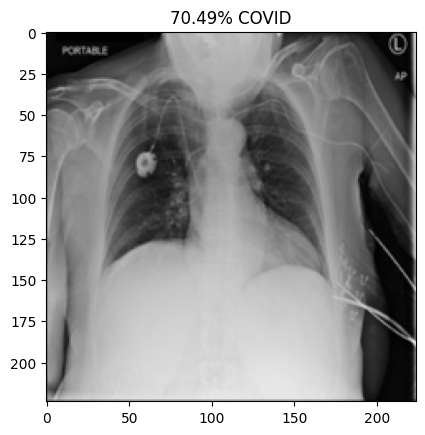

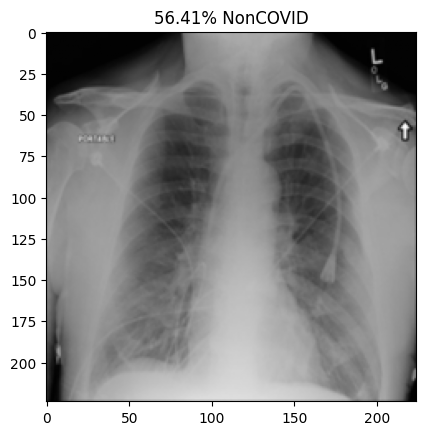

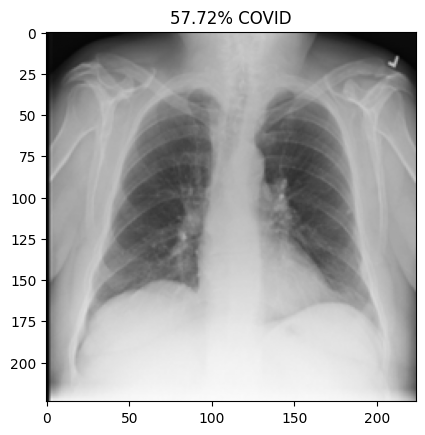

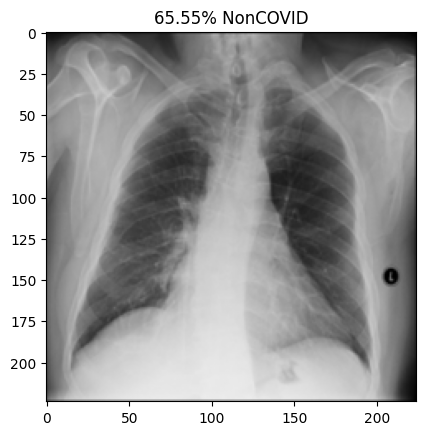

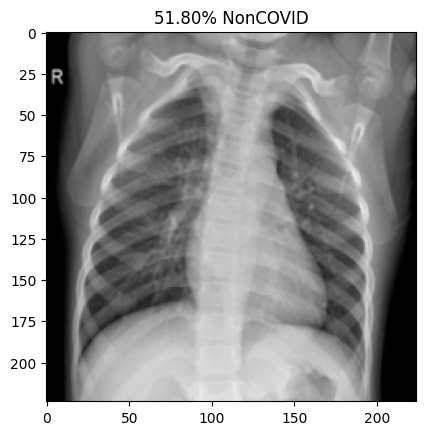

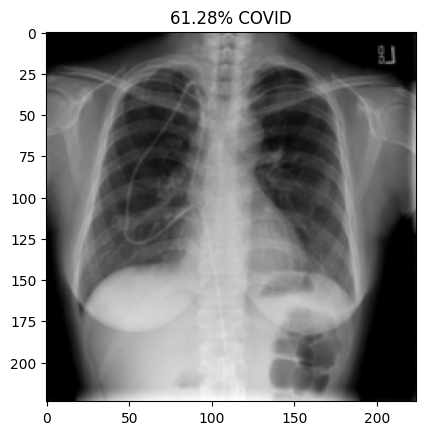

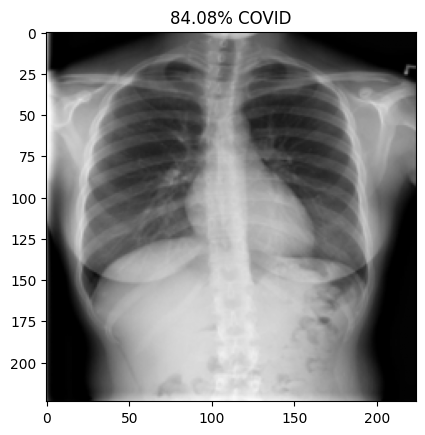

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
    plt.title(f'{probability[1]*100:.2f}% COVID')
  else:
    plt.title(f'{(1-probability[1])*100:.2f}% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()
#Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Confusion Matrix without Normalization


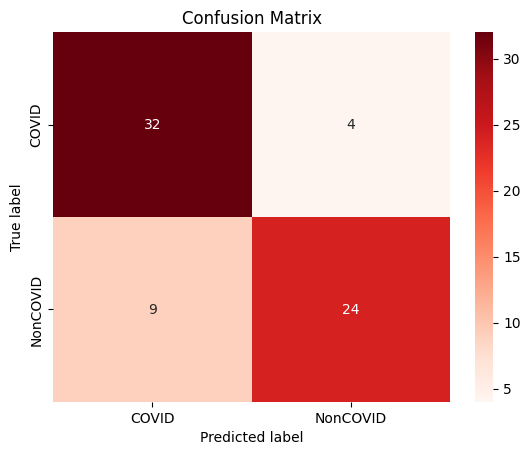

In [ ]:
def plot_confusion_matrix (normalize):
  classes = ['COVID', 'NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin, normalize=normalize)
  sns.heatmap (cn, cmap='Reds', annot=True)
  plt.xticks (tick_marks, classes)
  plt.yticks (tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        36
           1       0.86      0.73      0.79        33

    accuracy                           0.81        69
   macro avg       0.82      0.81      0.81        69
weighted avg       0.82      0.81      0.81        69



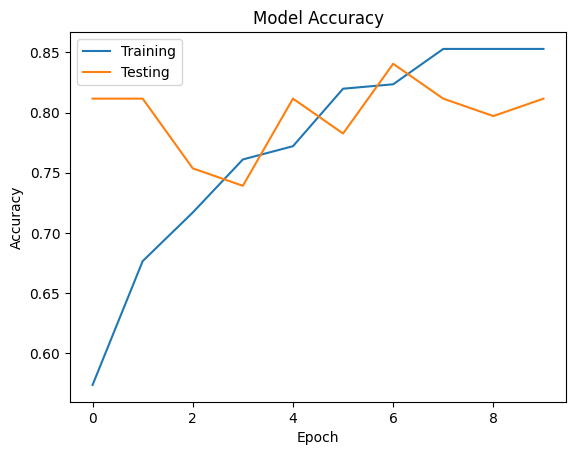

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()